In [1]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastpip import pip
from scipy.signal import savgol_filter    
import scipy
from scipy.optimize import curve_fit

# Preliminar analysis

In this script, I will try to put everything togheder to compute the transition among state ABAB to AAAA obtained by changing the magnetic interaction among particles from purely repulsive to purely attractive. How the magnetic field change in each experiment is explained and computed in script Setting_MagneticField.ipynb. 

In this script, the analisis goes through this points:

    1. find the bifurcation point
    2. Linear fit of the two parts of the channel to refine the bifurcation point
    3. Choose weather the particles go up or down
    4. Pair the particles by NN
    5. Compute the pagnetization value of NN

## 1. 
The interaction cut off will be obtained from the magnetic susceptibility calculation. At 21 mT the particles reach a maximum distance of approx 70 $\mu m$. The size of the particles is 18.82 $\mu m$.

  <span style="color:red">To do: Take an image of scale bar with 10x Objective!</span>

## 2. 
To do that I need to have the tracking trajectories

    Solved: Trajectories obtained in Script Automatic_Tracking

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments"

#filenames = [file for file in glob.glob(
#    os.path.join(directory,('*_tracking.dat')))]
#filenames

In [3]:
name = 'EXP2_2023_03_23_11_47_08'

In [4]:
trj = pd.read_csv(os.path.join(directory,(name+'_tracking.dat')),sep = '\t', usecols = ['frame','particle','x','y'])

In [5]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(26,
 array([   1,    2,    5,    7,   18,   19,   20,   22,   27,   29,   50,
          55,   56,   57,   59,   60,   61,  150, 2311, 3813, 4329, 4346,
        6015, 6214, 6516, 7803]))

# Checking tracking

In [6]:
# trj = trj.query('frame < 3600')

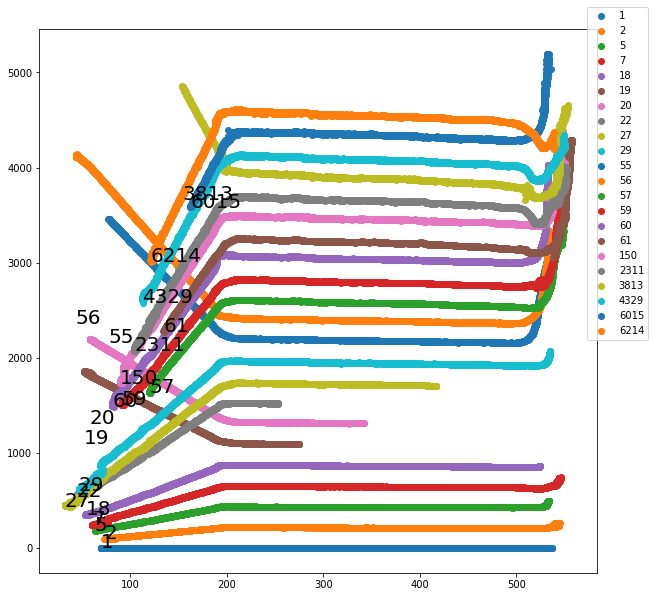

In [12]:
fig, ax = plt.subplots(1, figsize = (10,10))
i = 0
for p, gr in trj.groupby('particle'):
    
    plt.plot(gr.x, gr.y*i, 'o', label = p)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.text(gr.x.min(), gr.y.min()*i, s = str(p), size = 20)
    
    i = i+1

In [11]:
trj = trj[trj.particle != 7803] # To drop unuseful particles

In [13]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(22,
 array([   1,    2,    5,    7,   18,   19,   20,   22,   27,   29,   55,
          56,   57,   59,   60,   61,  150, 2311, 3813, 4329, 6015, 6214]))

# Functions used during analysis

In [14]:
def y_bifurcation_position(df):
    """In this function I will locate the bifurcation position"""
    
    y, x , _ = plt.hist(df['y'], bins = 40, )
    y_bif = x[np.argmax(y)]
    
    return y_bif, df

def x_bifurcation_position(df, y_bif):
    """In this function I will find the x value of the bifurcation"""
    
    particles = df.particle.unique()
    points = []
    for i in particles:
        
        particle = trj.query('particle =='+str(i))

        data = np.stack((particle.x, particle.y), axis=-1)
        points.append(pip(data,4))
    
    points_ar = np.array(points)
    new_df = points_ar.reshape((len(points_ar[0])*len(points_ar),2))
    df = pd.DataFrame(data=new_df, columns = ['x', 'y'])
    y_bifurcation_plus = y_bif+10
    y_bifurcation_minus = y_bif-10

    df_filtered = df.query('y < '+str(y_bifurcation_plus)+' & y > '+str(y_bifurcation_minus))
    x_bif = df_filtered.x.min()
    return x_bif

In [15]:
def improve_x_and_y_bif(trj, x_bif, y_bif):
    
    """This function will improve the first estimation of x_bif and y_bif
        and will return a fit of the channel"""
    x_int = []
    y_int = []
    fit=[]
    
    for i in range(0,len(trj['particle'].unique())):
        
        particle = trj['particle'].unique()[i] # Select a particle trj
        
        print(particle)

        x1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).x
        y1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).y

        x2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).x
        y2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).y
            
        fit1 = np.poly1d(np.polyfit(x1, y1, 1)) # fit biburcation
        fit2 = np.poly1d(np.polyfit(x2, y2, 1)) # fit channel

        fit.append(np.poly1d(np.polyfit(x2, y2, 1))) # fit channel
        # compute intersection among fits
        x_int.append((fit2[0]-fit1[0])/(fit1[1]-fit2[1]))
        y_int.append(fit1[1]*x_int[i]+fit1[0])
        
    x_int = np.mean(x_int)
    y_int = np.mean(y_int)
    
    return x_int, y_int, fit

In [16]:
def up_or_down(df, y_bif):
    
    """This function indicates which channel the particle has choose.
    The information is stored in the column bif."""
    
    df_trj = df[df.duplicated(subset=['frame'], keep=False)]  # Keep only frames that have more than one particle

    df_trj['bif'] = np.NaN
    for p,df in df_trj.groupby('particle'):
        
        if df.iloc[-1].y > y_bif:
            df_trj.loc[trj.particle==p,'bif'] = 'UP'
        else:
            df_trj.loc[trj.particle==p,'bif']= 'DOWN'
        
    return df_trj

In [17]:
def create_pairs(df, frame):
    """This function generates pair of particles. A pair of particle is defined 
    when one particles enter to the channel after the other. So, consecutive
    particles will be part of a pair.
    This function works for one frame"""

    df_f = df.query('frame == '+str(frame)) # First select a frame

    df_order = df_f.sort_values(by = ['x'])       # Order the x column in ascendent values, 
                                                  # this will be the order of particles entering the chanel. 
    new_df = []
    keys = []
    p1 = []
    p2 = []
    j = 2
    
    for i in range(0, len(df_order)-1):       
        
        p1.append(df_order.iloc[i:j].particle.values[0])
        p1.append(df_order.iloc[i:j].particle.values[0])


        p2.append(df_order.iloc[i:j].particle.values[1])
        p2.append(df_order.iloc[i:j].particle.values[1])

        new_df.append(df_order.iloc[i:j])  # Join consecutive rows, generating pairs
      

        keys.append(i)
        j = j +1
    p1 = pd.DataFrame({'p1':p1})
    p2 = pd.DataFrame({'p2':p2})

    final_df = pd.concat(new_df, keys = keys, names = ['pairs','index'])
    pairs = pd.concat([p1,p2], axis = 1)
    
    final_df['p1'] = pairs['p1'].values
    final_df['p2'] = pairs['p2'].values
    
    return final_df

In [18]:
def magnetization(df, frame):
    
    """Magnetization is equal to 1 when the 2 particles choose the same channel
        Magnetization is equal to 0 when the particles choose different channels"""
    
    df = df.query('frame == '+str(frame))
    magnetization = []
    for ind,group in df.groupby(['pairs']):

        if len(np.unique(group.bif)) == 2:

            magnetization.append(0)
            magnetization.append(0)

        else:

            magnetization.append(1) 
            magnetization.append(1)


    df['magnetization'] = magnetization
    return df

In [19]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    df['distance'] = np.NaN # Crate new column
    dx = []
    dy = []
    grouped = df.groupby(['frame','pairs'])
    for name,group in grouped:
        
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
    
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
    
    df['dx'] = dx
    df['dy'] = dy
    
    return df

In [20]:
def check_analysis(trj_initial,last_df_analyzed):
    
    n_of_particles = len(trj_initial['particle'].unique())
    n_of_pairs = len(last_df_analyzed.groupby(['p1','p2']).size())
    
    if (n_of_particles == n_of_pairs+1):
        
        print("Analysis succesfully performed of video")
    else:
        print("Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs")

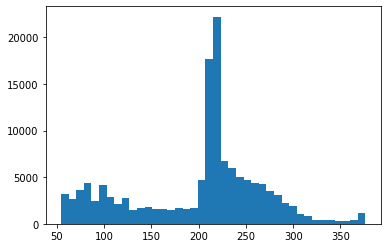

In [21]:
y_bif, df = y_bifurcation_position(trj)
x_bif = x_bifurcation_position(trj, y_bif)

In [22]:
x_bif

187.35506895717398

In [23]:
x_bif, y_bif, fit = improve_x_and_y_bif(trj,x_bif, y_bif)


1
2
5
7
18
19
20
22
27
29
55
56
57
59
60
61
150
2311
3813
4329
6015
6214


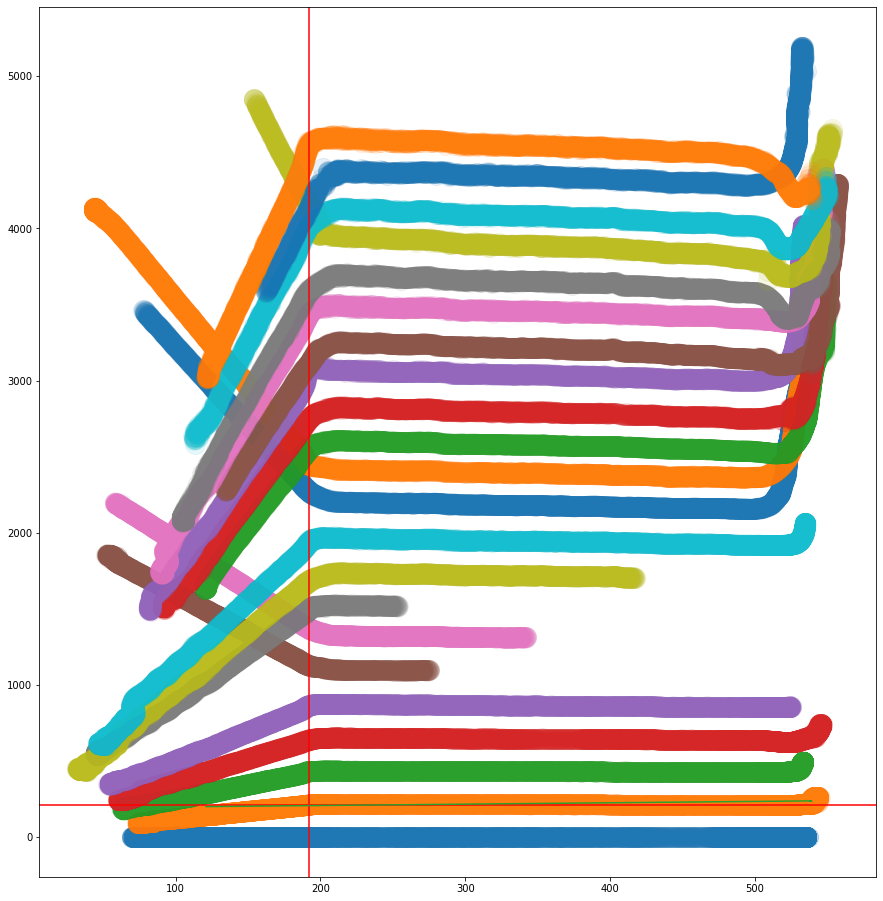

In [24]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in trj.groupby("particle"):
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [25]:
fit

[poly1d([8.98473976e-02, 1.90669219e+02]),
 poly1d([6.29257196e-02, 1.97586608e+02]),
 poly1d([4.03167403e-02, 2.05441681e+02]),
 poly1d([3.72442131e-02, 2.04343651e+02]),
 poly1d([-1.14102399e-02,  2.19921552e+02]),
 poly1d([-9.39930036e-02,  2.42821225e+02]),
 poly1d([-5.45989156e-02,  2.35487962e+02]),
 poly1d([8.06646071e-02, 1.98813982e+02]),
 poly1d([5.78752931e-04, 2.14753891e+02]),
 poly1d([5.77427152e-03, 2.14767518e+02]),
 poly1d([  0.24329301, 145.98650811]),
 poly1d([1.70786912e-01, 1.71843256e+02]),
 poly1d([  0.17643154, 160.47898338]),
 poly1d([1.34571209e-01, 1.73263554e+02]),
 poly1d([1.30555940e-01, 1.82042059e+02]),
 poly1d([1.19772821e-01, 1.74617832e+02]),
 poly1d([9.31471470e-02, 1.87653251e+02]),
 poly1d([1.07681596e-02, 2.10225349e+02]),
 poly1d([2.10685859e-02, 2.12008799e+02]),
 poly1d([-1.18122251e-02,  2.17956166e+02]),
 poly1d([6.84909497e-02, 1.96929644e+02]),
 poly1d([-4.24163405e-02,  2.28742204e+02])]

In [26]:
inter = up_or_down(trj,y_bif)

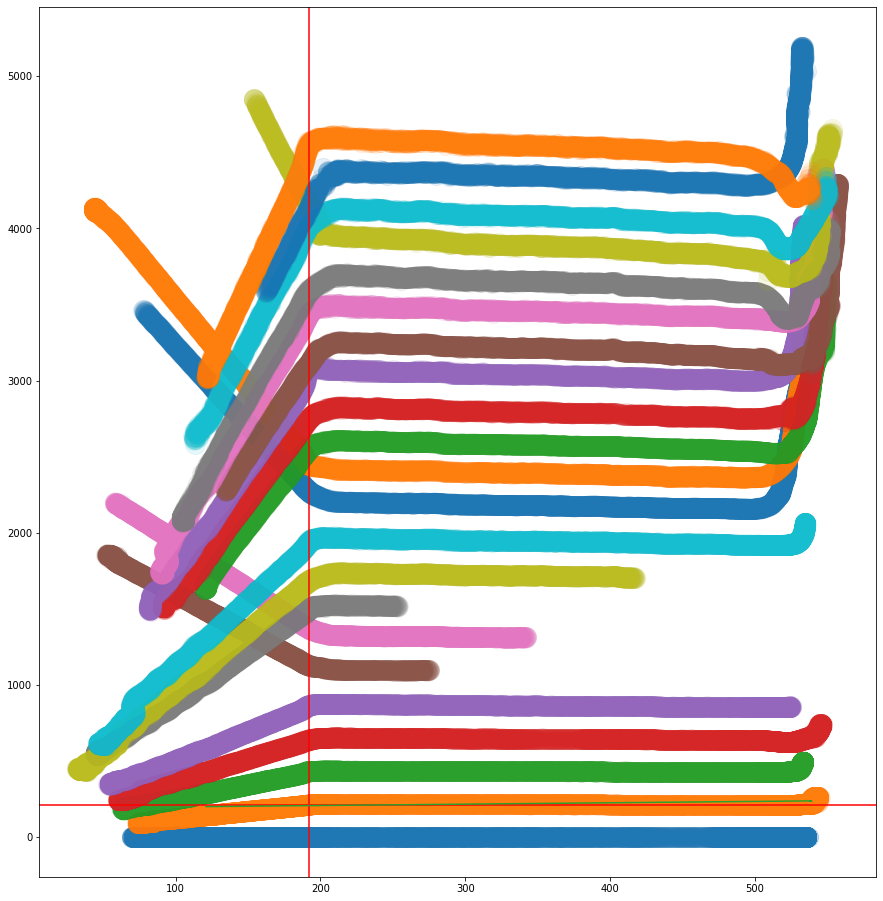

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in inter.groupby("particle"):
    
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [28]:
df_x = inter.query('x > '+str(x_bif))
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

1
2
5
7
18
19
20
22
27
29
55
56
57
59
60
61
150
2311
3813
4329
6015
6214


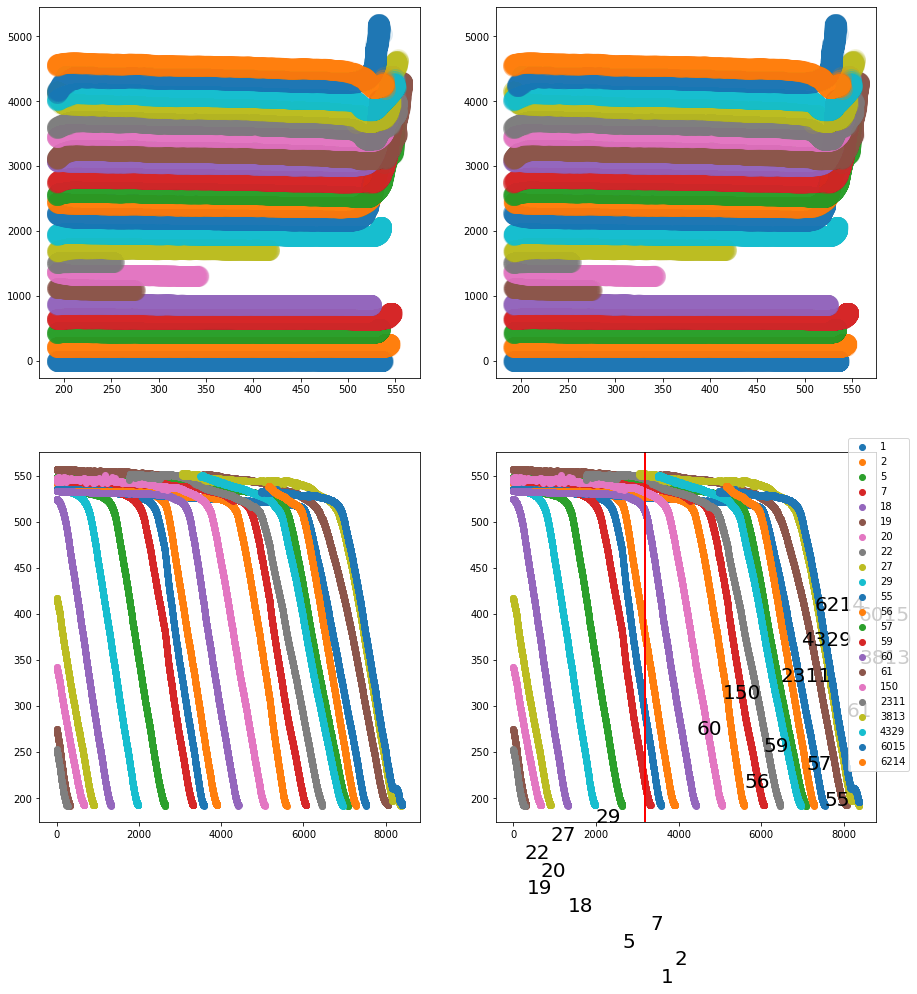

In [29]:
fig, (ax0,ax1) = plt.subplots(2,2, figsize = (15,15))

j = 0
for p,trj_p in df_x.groupby("particle"):
    
    ax0[0].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[0].plot(trj_p.frame, trj_p.x, 'o')
    j = j+1
    
j = 0
for p,trj_p in df_d.groupby("particle"):
    
    ax0[1].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[1].plot(trj_p.frame, trj_p.x, 'o', label = str(p))
    ax1[1].text(trj_p.frame.max(), trj_p.x.min()*0.1*j , s = str(p), size = 20)
    ax1[1].axvline(x=3200, color='r', linestyle='-')
    ax1[1].legend(bbox_to_anchor=(1.1, 1.05))


    print(str(p))

    

    j = j+1

In [28]:
#df_d.query('frame == 3200')

In [30]:
%%time
df_last = []

df_x = inter.query('x > '+str(x_bif)+'& x < 450') # 500 is the starting point of the channel
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

for frame in df_d['frame'].unique(): # Do analysis frame by frame
    
    pairs = create_pairs(df_d, frame)
    mag = magnetization(pairs, frame)
    df_last.append(d(mag, 1, 1)) # I need to introduce the pix/um conversion.

    
last = pd.concat(df_last)    

CPU times: user 1min 19s, sys: 1.36 s, total: 1min 20s
Wall time: 1min 19s


In [31]:
check_analysis(trj, last)

Analysis succesfully performed of video


In [32]:
len(last.particle.unique())

22

In [33]:
last.groupby(['p1','p2']).size(), len(last.groupby(['p1','p2']).size())

(p1    p2  
 1     2       1318
 2     60       930
 5     7        580
 7     1       1288
 18    29       590
 19    20       640
 20    27      1348
 22    19       504
 27    18      1030
 29    5        688
 55    61      1450
 56    59      1112
 57    6214    1672
 59    2311    1582
 60    150      810
 61    3813    1768
 150   56       800
 2311  4329    1424
 3813  6015    2234
 4329  57      2088
 6214  55      1796
 dtype: int64,
 21)

In [47]:
last1 = last[last.p1 != 24] # To drop unuseful particles

In [48]:
last1.groupby(['p1','p2']).size()

p1    p2  
8     86      1632
26    33      2412
27    41      1824
28    24      1688
33    147     2470
39    27      1650
41    8       2238
86    1967    1116
147   39      1624
307   15      1242
1967  72      2084
2053  307     1416
dtype: int64

In [40]:
last1 = last[(last.p1 == 59) & (last.p2 == 1836)]
last1.groupby(['p1','p2']).size() 

p1  p2  
59  1836    1108
dtype: int64

In [52]:
last1 = last.query('p1 == 16 & p2 == 1415')


In [ ]:
last1.groupby(['p1','p2']).size() 

In [ ]:
last.groupby(['p1','p2']).size() 

In [ ]:
last1 = last[(last['p1'] == 14) & (last['p2'] == 1680)]
last1.groupby(['p1','p2']).size() 

# Next step

Now I need to compute the main distance in the channel for pairs of particles and associate a magnetization value to this pair.

In [34]:
def distance_and_magnetization(df, x_bif):
    
    output = df.groupby(['p1','p2']).mean()
    output['dx_err'] = df.groupby(['p1','p2']).dx.std()/np.sqrt(df.groupby(['p1','p2']).count()['dx'])
    output['dy_err'] = df.groupby(['p1','p2']).dy.std()/np.sqrt(df.groupby(['p1','p2']).count()['dy'])

    
    return output

In [35]:
output = distance_and_magnetization(last,x_bif)
output

,,frame,particle,y,x,magnetization,distance,dx,dy,dx_err,dy_err
p1,p2,,,,,,,,,,
1,2,3251.003035,1.5,216.591362,316.617831,1.0,NaN,85.287891,1.681497,0.055532,0.015525
2,60,3676.004301,31.0,216.937626,311.839776,1.0,NaN,138.810174,1.189779,0.155410,0.016873
5,7,2495.500000,6.0,216.585116,315.780423,1.0,NaN,196.629448,4.069336,0.136205,0.022187
7,1,2998.504658,4.0,216.512073,306.885314,1.0,NaN,79.495713,1.042357,0.152443,0.016755
18,29,1178.006780,23.5,216.746692,315.667657,1.0,NaN,186.560010,3.114444,0.141197,0.024678
19,20,159.500000,19.5,220.034748,266.096737,1.0,NaN,73.670788,1.304155,0.133258,0.058342
20,27,336.500000,23.5,217.974572,293.865329,0.0,NaN,66.237067,5.599693,0.152278,0.046005
22,19,125.607143,20.5,218.583069,228.910463,0.0,NaN,18.200951,2.388033,0.154335,0.058428
27,18,647.000000,22.5,215.867379,310.888890,1.0,NaN,125.786304,1.147451,0.286114,0.036984


In [36]:
output.to_csv('magnetization_'+name+'.dat', sep = '\t')